# Decision Tree - with SMOTE Balanced Data from MinMaxScaler

## Prepruning with different parameters

Various parameters and values are tested individually. Evaluation is done by CV and external.


### Load Packages

In [1]:
import pickle
from datetime import datetime as dt
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

from imblearn.over_sampling import SMOTE

### Load data

In [2]:
# import dataset from pickle
X_train, X_test, y_train, y_test = pickle.load( open( "../../pickles/intercorr_app2_MinMaxScaler_smote_20210711_214137.pickle", "rb" ) )

### Define Scoring functions for 

Cross-validation will be performed for each scoring parameter given in the "scoring"-dict.

In [3]:
scoring = {'accuracy': 'accuracy',
           'bal_acc' : 'balanced_accuracy',
           'f1' : 'f1',
           'recall': 'recall',
           'precision' : 'precision',
           'roc_auc' : 'roc_auc',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [4]:
def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=StratifiedShuffleSplit(20)):
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}

### Evaluate with Test Data

For each model built, calculate the outcome prediction and compare to the independent test set.

In [5]:
def calc_test_scores(y_test, y_predicted):
    test_scores = {'Balanced Accuracy' : balanced_accuracy_score(y_test, y_predicted),
                   'Accuracy': accuracy_score(y_test, y_predicted),
                   'ROC_AUC': roc_auc_score(y_test, y_predicted),
                   'f1_score': f1_score(y_test, y_predicted),
                   'recall_score' : recall_score(y_test, y_predicted),
                   'specificity_score' : recall_score(y_test, y_predicted, pos_label=0),
                   'precision_score' : precision_score(y_test, y_predicted),
    }
    return test_scores


def validate_against_test(obj, X_test, y_test):
    y_predicted = obj.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    scores = calc_test_scores(y_test, y_predicted)
    return scores, cm

### Calculations

Calculate DTs with given parameter and parameter values. Write output to dict for plotting.

In [6]:
def calculation(logic_name, logic_values):

    results = []
    test_res = []

    for val in logic_values:
        param = {logic_name : val}
        clf = DecisionTreeClassifier(random_state = 78, **param)
        results.append(average_score_on_cross_val_classification(clf, X_train, y_train))
        clf = clf.fit(X_train, y_train)
        scores, confmatrix = validate_against_test(clf, X_test, y_test)
        test_res.append((scores, confmatrix))
    return results, test_res

In [7]:
logic = {'max_depth' : [int(x) for x in np.linspace(1, 25, num = 25)], 
         'min_samples_split' : [int(x) for x in np.linspace(2, 40, num = 39)],
         'min_samples_leaf' : [int(x) for x in np.linspace(1, 20, num = 20)],
         'min_weight_fraction_leaf' : [float(x) for x in np.linspace(0, 0.3, num = 100)],
         'min_impurity_decrease' : [float(x) for x in np.linspace(0, 0.03, num = 100)],
         'class_weight' : [{0:float("{0:.2f}".format(x)), 1:1-float("{0:.2f}".format(x))} for x in np.linspace(0, 1, num = 51)]
        }

In [8]:
results_logic = {}

In [9]:
for k, v in logic.items():
    results, test_res = calculation(k, v)
    results_logic[k] = {'results' : results, 'test_res' : test_res}
    

/Users/sandro/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot results

In [10]:
def numfmt(x, pos): # your custom formatter function: divide by 50
    s = '{}'.format(x / 50)
    return s

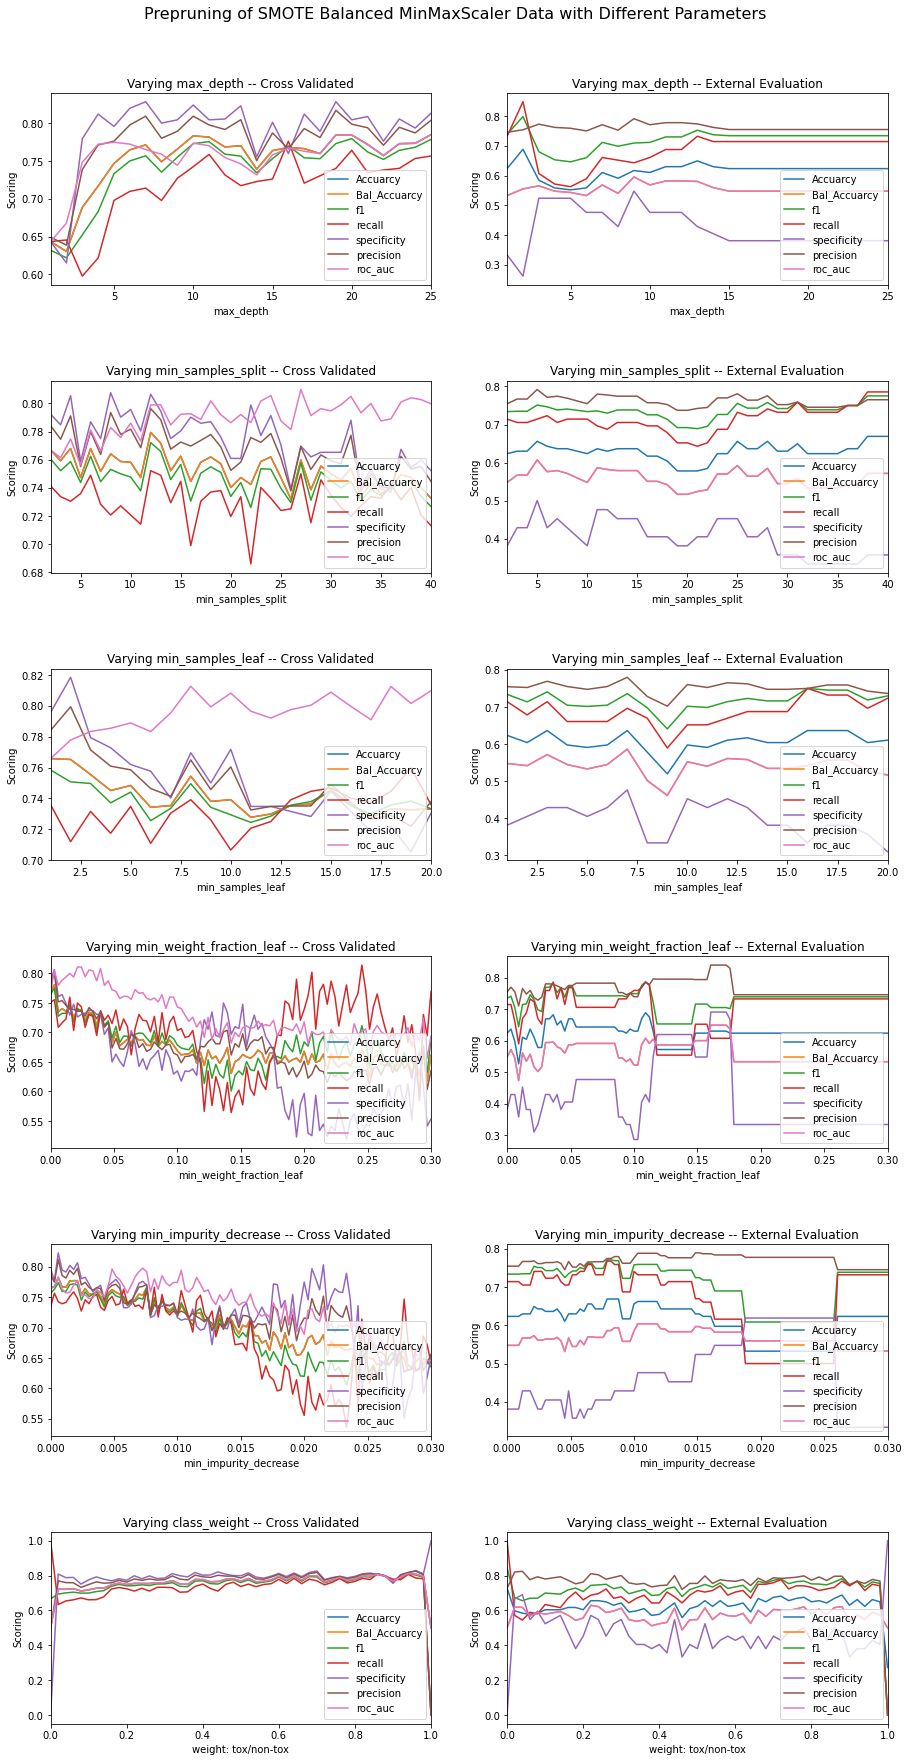

In [11]:
fig, axes = plt.subplots(len(results_logic.keys()), 2, figsize=(15,30))
plt.subplots_adjust(hspace = 0.5)

fig.suptitle('Prepruning of SMOTE Balanced MinMaxScaler Data with Different Parameters', fontsize=16, y=0.92)

counter = 0
for k,v in results_logic.items():    
    
    ax1 = axes[counter][0]
    ax2 = axes[counter][1]
    
    values = logic[k]

    if k == 'class_weight':
        values = np.arange(len(logic[k]))
    
    ax1.plot(values, [r['test_accuracy'] for r in v['results']], label='Accuarcy')
    ax1.plot(values, [r['test_bal_acc'] for r in v['results']], label='Bal_Accuarcy')
    ax1.plot(values, [r['test_f1'] for r in v['results']], label='f1')
    ax1.plot(values, [r['test_recall'] for r in v['results']], label='recall')
    ax1.plot(values, [r['test_specificity'] for r in v['results']], label='specificity')
    ax1.plot(values, [r['test_precision'] for r in v['results']], label='precision')
    ax1.plot(values, [r['test_roc_auc'] for r in v['results']], label='roc_auc')
    
    ax1.set_xlim([values[0], values[-1]])
    ax1.legend(loc='lower right')
    ax1.set_xlabel('%s' %(k)) 
    ax1.set_ylabel('Scoring')
    ax1.set_title('Varying %s -- Cross Validated' %(k))
    
    
    ax2.plot(values, [r[0]['Accuracy'] for r in v['test_res']], label='Accuarcy')
    ax2.plot(values, [r[0]['Balanced Accuracy'] for r in v['test_res']], label='Bal_Accuarcy')
    ax2.plot(values, [r[0]['f1_score'] for r in v['test_res']], label='f1')
    ax2.plot(values, [r[0]['recall_score'] for r in v['test_res']], label='recall')
    ax2.plot(values, [r[0]['specificity_score'] for r in v['test_res']], label='specificity')
    ax2.plot(values, [r[0]['precision_score'] for r in v['test_res']], label='precision')
    ax2.plot(values, [r[0]['ROC_AUC'] for r in v['test_res']], label='roc_auc')
    
    ax2.set_xlim([values[0], values[-1]])
    ax2.legend(loc='lower right')
    ax2.set_xlabel('%s' %(k)) 
    ax2.set_ylabel('Scoring')
    ax2.set_title('Varying %s -- External Evaluation' %(k))

    if k == 'class_weight':
        yfmt = tkr.FuncFormatter(numfmt)
        ax1.xaxis.set_major_formatter(yfmt)
        ax2.xaxis.set_major_formatter(yfmt)
        ax1.set_xlabel('weight: tox/non-tox')
        ax2.set_xlabel('weight: tox/non-tox')

    
    
    counter += 1


### Save Results

In [12]:
out = (logic, results_logic)
timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
filename = '../../pickles/DT_MinMax_smote_preprun_%s.pickle' %timestamp
filehandler = open(filename, 'wb')
pickle.dump(out, filehandler)

### Reload Results

In [13]:
#out2 = pickle.load( open( "", "rb" ) )